# Process Time Series

In [2]:
import import_ipynb
from ExtractShapelets import vector_accer, plot_candidates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys


In [3]:
# Use %store to retrieve the variable
%store -r z_jump
%store -r z_walk
%store -r z_skip

%store -r g_jump
%store -r g_walk
%store -r g_skip

max_integer_value = sys.maxsize

## Cut activity time series to cycles

In [5]:
def find_peak(time_series, top_percent):
    """
    This is a method to find all the peaks in a time series, including both local and global

    :time_series: is panda.series stores activity time series data
    :top_percent: is the extent of the peak value, eg. 0.1 means take top 0.1 high as peak
    :return: peaks is all local peaks index, threshold is the accepted lowest peak, thres_peak is the global peak
    """
    time_value_arr = time_series.values
    peaks = []
    peaks_value = []
    for i in range(0, len(time_value_arr) - 1):
        if (time_value_arr[i] > time_value_arr[i - 1] and time_value_arr[i] > time_value_arr[i + 1]):
            peaks_value.append(time_value_arr[i])
            peaks.append(i)
    peaks_value.sort(reverse=True)
    threshold = peaks_value[int(top_percent * len(peaks_value))]
    thres_peaks = []
    for peak in peaks:
        if time_value_arr[peak] >= threshold:
            thres_peaks.append(peak)
    return peaks, threshold, thres_peaks

def cycle_length_distribution(thres_peaks):
    """
    This is a method to check thr cycle length distribution
    :thres_peaks: is a global peaks array under a percent
    :return: cycle length array
    """
    cycle_length = []
    for i in range(0, len(thres_peaks) - 1):
        cycle_length.append(thres_peaks[i + 1] - thres_peaks[i])
    return cycle_length


def find_cycle(time_series, top_percent):
    """"
    This is a method to find all the cycles

    :time_series: is action panda.series value
    :top_percent: is the minimum of global maximum
    :return: an array of array, each nested array is the data point value
    """
    _, _, peaks = find_peak(time_series, top_percent)
    time_value_arr = time_series.values
    cycles_arr = []
    cur_peak_index = 0
    for i in range(len(time_value_arr)):
        if cur_peak_index < len(peaks) - 1 and i == peaks[cur_peak_index]:
            cur_peak_index += 1
            cycle = []
            while(i <= peaks[cur_peak_index]):
                cycle.append(time_value_arr[i])
                i += 1
            # leave the peak to next start
            i -= 1
            # add cycle to cycles
            cycles_arr.append(cycle)
    return cycles_arr


def cycle_distribution_metric(cycle_length, supposed_cycle, allow_range):
    """
    This is a method use to decide whether a cycle_length array distribution is good or not, by calculate the mean and average of length

    :cycle_length: an int array with the value of the cycle_length(no need to be unique)
    :supposed_cycle: this is the length of the shapelets
    :allow_range: is allowed percent of the cycle length
    :return: 1
    """
    arr = np.array(cycle_length)
    mean = np.mean(arr)
    std_deviation = max_integer_value
    # The purpose of restrict the mean is avoiding the extreme high or low cycle
    if (mean >= supposed_cycle * (1 - allow_range) and mean <= supposed_cycle * (1 + allow_range)):
        squared_diff = (arr - mean) ** 2
        average_of_squares = np.mean(squared_diff)
        std_deviation = np.sqrt(average_of_squares)
    return std_deviation


def best_thres(time_series, supposed_cycle, allow_range):
    """
    This is a method to help to find the best percent, under which most of the cycle is in same length

    :thres_peaks: is a global peaks array under a percent
    """
    min_diff = max_integer_value
    best = 0
    percent = 0.01
    while percent < 0.5:
        _, _, thres_peaks = find_peak(time_series, percent)
        cycle_length = cycle_length_distribution(thres_peaks)
        # print(cycle_length)
        # the smaller of max - min, the better the thres_percent
        # cur = (max(cycle_length) - min(cycle_length)) / min(cycle_length)
        cur = cycle_distribution_metric(cycle_length, supposed_cycle, allow_range)
        # if no cycle minimum value, it will take the one length as the best cycle, because max and min are same value in this situation
        if (len(thres_peaks) > 5 and cur <= min_diff):
            best = percent
            min_diff = cur
        percent = percent + 0.01
    return best

### Get best threshold to cut the cycles

In [6]:
print("---------------------Candidate 1-----------------------------")
best_jump = best_thres(z_jump, 50, 0.3) # how to get the supposed length
best_walk = best_thres(z_walk, 100, 0.3)
best_skip = best_thres(z_skip, 100, 0.3)
print("best jump thres is:", best_jump)
print("best walk thres is:", best_walk)
print("best skip thres is:", best_skip)

print("---------------------Candidate 2-----------------------------")
best_jump = best_thres(g_jump, 50, 0.3) # how to get the supposed length
best_walk = best_thres(g_walk, 100, 0.3)
best_skip = best_thres(g_skip, 100, 0.3)
print("best jump thres is:", best_jump)
print("best walk thres is:", best_walk)
print("best skip thres is:", best_skip)

---------------------Candidate 1-----------------------------
best jump thres is: 0.15
best walk thres is: 0.11999999999999998
best skip thres is: 0.09999999999999999
---------------------Candidate 2-----------------------------
best jump thres is: 0.20000000000000004
best walk thres is: 0.18000000000000002
best skip thres is: 0.10999999999999999


### Store cycles in an array

In [7]:
def get_cycles(time_series, thres):
    peaks, threshold, thres_peaks = find_peak(time_series, thres)
    print("all peaks: ", peaks)
    print("valid peak value: ", threshold)
    print("valid peak index: ", thres_peaks)
    print("cycle length :", cycle_length_distribution(thres_peaks))
    cycles = find_cycle(time_series, thres)
    # Plot each sub-array
    for arr in cycles:
        plt.plot(np.array(arr))
    return cycles

### Candidate 1

all peaks:  [3, 16, 20, 31, 36, 47, 51, 63, 69, 82, 93, 99, 108, 130, 133, 142, 150, 164, 170, 189, 199, 207, 222, 230, 244, 252, 256, 264, 275, 282, 288, 296, 300, 312, 318, 325, 332, 344, 347, 355, 369, 375, 387, 394, 406, 410, 420, 428, 433, 443, 452, 464, 472, 477, 484, 490, 500, 516, 521, 532, 538, 545, 554, 563, 567, 574, 586, 593, 611, 631, 644, 650, 658, 667, 677, 688, 695, 704, 710, 727, 736, 749, 757, 773, 779, 787, 801, 814, 827, 837, 852, 862, 872, 877, 885, 888, 905, 921, 929, 942, 949, 958, 965, 979, 995, 999, 1009, 1016, 1023, 1032, 1036, 1041, 1052, 1059, 1071, 1086, 1098, 1104, 1109, 1120, 1128, 1134, 1143, 1150, 1153, 1167, 1180, 1184, 1191, 1201, 1219, 1224, 1235, 1240, 1248, 1257, 1267, 1279, 1286, 1294, 1300, 1307, 1316, 1324, 1327, 1337, 1349, 1354, 1362, 1371, 1381, 1394, 1401, 1407, 1414, 1420, 1431, 1441, 1443, 1452, 1464, 1471, 1477, 1487, 1495, 1497, 1509, 1528, 1536, 1546, 1554, 1558, 1568, 1581, 1588, 1594, 1604, 1611, 1625, 1631, 1640, 1656, 1675, 1682, 16

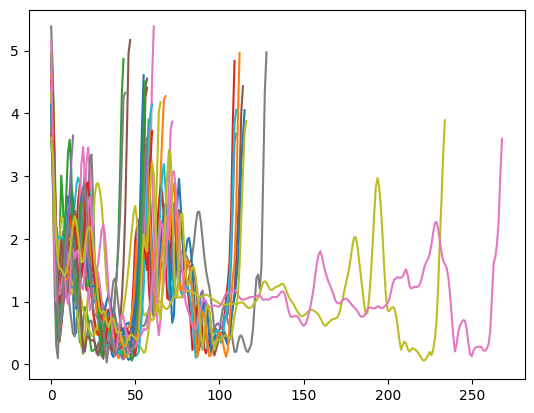

In [8]:
z_skip_cycles = get_cycles(z_skip, 0.1)

# Use %store to store the variable
%store z_skip_cycles

### Candidate 2

all peaks:  [5, 14, 26, 34, 45, 63, 75, 80, 88, 101, 108, 115, 126, 137, 153, 158, 162, 175, 184, 188, 192, 204, 213, 223, 232, 238, 246, 250, 256, 271, 276, 279, 288, 296, 304, 310, 315, 321, 327, 337, 341, 348, 355, 367, 376, 392, 397, 400, 409, 417, 422, 427, 440, 449, 455, 459, 466, 473, 484, 492, 508, 516, 524, 532, 546, 564, 571, 577, 583, 592, 601, 609, 614, 624, 629, 633, 642, 647, 652, 662, 674, 682, 687, 694, 700, 709, 714, 720, 726, 740, 747, 759, 768, 779, 786, 797, 810, 820, 839, 845, 858, 863, 871, 879, 889, 897, 905, 909, 924, 931, 935, 943, 949, 957, 962, 971, 984, 995, 1003, 1011, 1017, 1022, 1026, 1033, 1043, 1051, 1057, 1065, 1072, 1082, 1094, 1098, 1109, 1114, 1118, 1127, 1135, 1141, 1150, 1157, 1168, 1179, 1187, 1204, 1216, 1228, 1234, 1238, 1246, 1261, 1266, 1270, 1280, 1287, 1291, 1301, 1309, 1324, 1329, 1335, 1350, 1359, 1367, 1377, 1380, 1388, 1401, 1408, 1413, 1419, 1428, 1449, 1455, 1461, 1473, 1481, 1493, 1501, 1508, 1516, 1531, 1540, 1544, 1551, 1559, 1570,

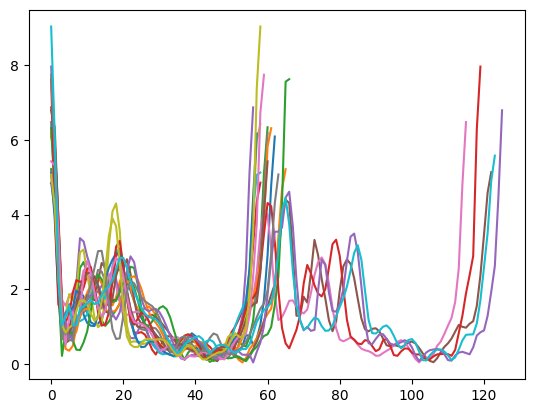

In [9]:
g_skip_cycles = get_cycles(g_skip, 0.11)

# Use %store to store the variable
%store g_skip_cycles